In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy import signal
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns

from tqdm import tqdm

import sys
sys.path.append('/Users/ag1880/Github_repos/Milstein-Lab/dentate_circuit_model/')
from optimize_dynamic_model import get_binary_input_patterns

%matplotlib inline

In [2]:
class dentate_network(nn.Module):
    def __init__(self, lr):
        self.lr = lr
        self.input_size = 7
        self.output_size = 128
        self.fbi_size = 7
        
        self.combined_size = self.output_size + self.fbi_size
                
        super().__init__()
                        
        self.rnn_out_fbi  = nn.RNN(self.input_size, self.output_size+self.fbi_size, nonlinearity='relu')
        self.readout = nn.Linear(self.combined_size, self.output_size)
        
        # Initialize weights
        self.rectify_weights()
#         self.rnn_out_fbi.weight_ih_l0.data[0:128].uniform_(0,1)
#         self.rnn_out_fbi.weight_hh_l0.data[128:135,0:128].uniform_(0,1)
#         self.rnn_out_fbi.weight_hh_l0.data[0:128,128:135].uniform_(-0.5,0)
    
        self.lossCriterion = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        
        
    def forward(self, input_pattern, rnn_activity):
        rnn_activity,_ = self.rnn_out_fbi(input_pattern,rnn_activity)
        return rnn_activity
    
    
    def rectify_weights(self):
        # zero the input->FB Inh weights
        self.rnn_out_fbi.weight_ih_l0.data[128:135] *= 0
        
        # zero the recurrent connections
        self.rnn_out_fbi.weight_hh_l0.data[0:128,0:128] *= 0     #recurrent output weights
        self.rnn_out_fbi.weight_hh_l0.data[128:135,128:135] *= 0 #recurrent FB Inh weights
        
        # constrain sign weights between populations
#         self.rnn_out_fbi.weight_ih_l0.data[0:128] = self.rnn_out_fbi.weight_ih_l0.data[0:128].clamp(0.001,100) #+ve rectify input->output
#         self.rnn_out_fbi.weight_hh_l0.data[128:135,0:128] = self.rnn_out_fbi.weight_hh_l0.data[128:135,0:128].clamp(0.001,100)  #+ve rectify output->FBI
#         self.rnn_out_fbi.weight_hh_l0.data[0:128,128:135] = self.rnn_out_fbi.weight_hh_l0.data[0:128,128:135].clamp(-100,-0.001) #-ve rectify FBI->output
    
    def train(self,epochs,time,all_patterns):
        losses = []
        
        for i in tqdm(range(epochs)):
            self.optimizer.zero_grad()
            
            pattern_index = np.random.randint(0,128)
            input_pattern = all_patterns[pattern_index].expand(1,1,self.input_size)
            
            rnn_activity = torch.zeros(1,1,self.combined_size)
            for t in range(time):
                rnn_activity = self.forward(input_pattern, rnn_activity)

            output = rnn_activity[0,0,0:128]
            target = torch.eye(128)[pattern_index]
            
            loss = self.lossCriterion(output,target)           
            loss.backward()
            self.optimizer.step()
            self.rectify_weights()
            
            losses.append(loss.detach())
        return losses

In [3]:
# Create network
dentate_net = dentate_network(lr=1)
time = 10
all_patterns = torch.tensor(get_binary_input_patterns(7)).type(torch.float32)

In [4]:
dentate_net

dentate_network(
  (rnn_out_fbi): RNN(7, 135)
  (readout): Linear(in_features=135, out_features=128, bias=True)
  (lossCriterion): MSELoss()
)

In [5]:
# Save initial state
w_init = {'out_in': dentate_net.rnn_out_fbi.weight_ih_l0.data[0:128].numpy().flatten(),
          'fbi_out': dentate_net.rnn_out_fbi.weight_hh_l0.data[128:135,0:128].numpy().flatten(),
          'out_fbi': dentate_net.rnn_out_fbi.weight_hh_l0.data[0:128,128:135].numpy().flatten()}

b_init = {'out_in': dentate_net.rnn_out_fbi.bias_ih_l0.data[0:128].numpy().flatten(),
          'fbi_out': dentate_net.rnn_out_fbi.bias_hh_l0.data[0:128].numpy().flatten(),
          'out_fbi': dentate_net.rnn_out_fbi.bias_hh_l0.data[128:135].numpy().flatten()}

output_init = []
mean_output_init = torch.zeros(time)
for pattern in all_patterns:
    rnn_activity = torch.zeros(1,1,dentate_net.combined_size)
    pattern = pattern.expand(1,1,pattern.shape[0])
    for t in range(time):
        rnn_activity = dentate_net.forward(pattern, rnn_activity)
        output_activity = rnn_activity[0,0,0:128].detach()
        mean_output_init[t] += torch.mean(output_activity)
    output_init.append(list(output_activity))
output_init = np.array(output_init)

In [6]:
# Train network
epochs = 10**5
losses = dentate_net.train(epochs, time, all_patterns)

100%|██████████| 100000/100000 [02:33<00:00, 651.84it/s]


In [7]:
# Save initial state
w_final = {'out_in': dentate_net.rnn_out_fbi.weight_ih_l0.data[0:128].numpy().flatten(),
          'fbi_out': dentate_net.rnn_out_fbi.weight_hh_l0.data[128:135,0:128].numpy().flatten(),
          'out_fbi': dentate_net.rnn_out_fbi.weight_hh_l0.data[0:128,128:135].numpy().flatten()}

b_final = {'out_in': dentate_net.rnn_out_fbi.bias_ih_l0.data[0:128].numpy().flatten(),
          'fbi_out': dentate_net.rnn_out_fbi.bias_hh_l0.data[0:128].numpy().flatten(),
          'out_fbi': dentate_net.rnn_out_fbi.bias_hh_l0.data[128:135].numpy().flatten()}

output_final = []
mean_output_final = torch.zeros(time)
for pattern in all_patterns:
    rnn_activity = torch.zeros(1,1,dentate_net.combined_size)
    pattern = pattern.expand(1,1,pattern.shape[0])
    for t in range(time):
        rnn_activity = dentate_net.forward(pattern, rnn_activity)
        output_activity = rnn_activity[0,0,0:128].detach()
        mean_output_final[t] += torch.mean(output_activity)
    output_final.append(list(output_activity))
output_final = np.array(output_final)

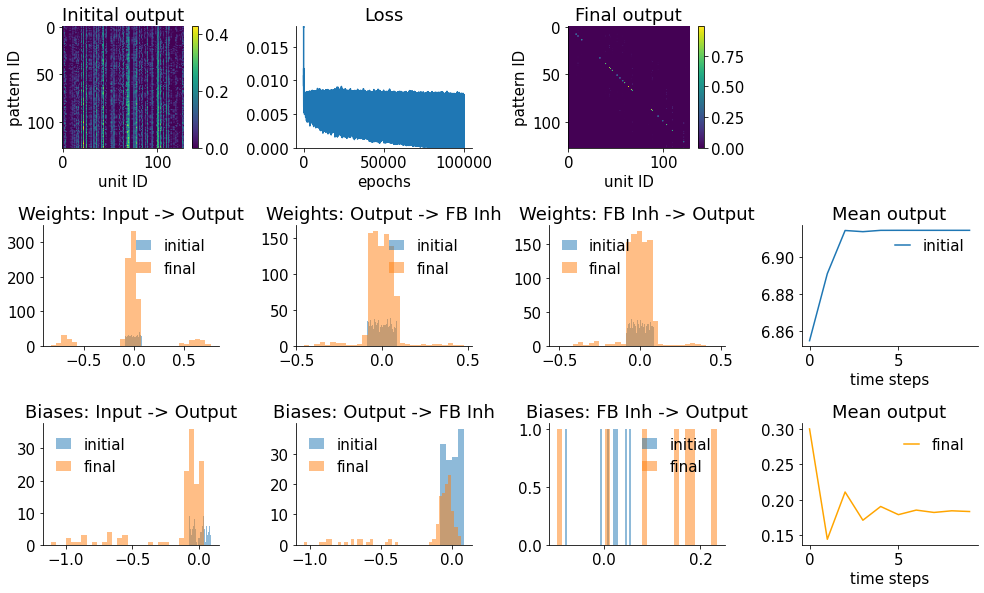

In [9]:
matplotlib.rcParams.update({'font.size': 15})

fig = plt.figure(figsize=(14,8.5))
axes = gs.GridSpec(nrows=3, ncols=12)
    
# Row 1: output activities
ax = fig.add_subplot(axes[0,0:3])
im = ax.imshow(output_init)
ax.set_title('Initital output')
ax.set_xlabel('unit ID')
ax.set_ylabel('pattern ID')
cbar = plt.colorbar(im, ax=ax)

ax = fig.add_subplot(axes[0,3:6])
ax.plot(losses)
ax.set_xlabel('epochs')
ax.set_title('Loss')
ax.set_ylim([0,np.max(losses)])
# ax.set_ylim([0,1])

ax = fig.add_subplot(axes[0,6:9])
im = ax.imshow(output_final)
ax.set_title('Final output')
ax.set_xlabel('unit ID')
ax.set_ylabel('pattern ID')
cbar = plt.colorbar(im, ax=ax)

ax = fig.add_subplot(axes[1,9:12])
ax.plot(mean_output_init,label='initial')
ax.set_title('Mean output')
ax.set_xlabel('time steps')
ax.legend(loc='best', frameon=False,handlelength=1)

ax = fig.add_subplot(axes[2,9:12])
ax.plot(mean_output_final,label='final',color='orange')
ax.set_title('Mean output')
ax.set_xlabel('time steps')
ax.legend(loc='best', frameon=False,handlelength=1)

# Row 2: weights
ax = fig.add_subplot(axes[1,0:3])
ax.hist(w_init['out_in'],30,alpha=0.5,label='initial')
ax.hist(w_final['out_in'],30,alpha=0.5,label='final')
ax.set_title('Weights: Input -> Output')
ax.legend(loc='best', frameon=False,handlelength=1)

ax = fig.add_subplot(axes[1,3:6])
ax.hist(w_init['fbi_out'],30,alpha=0.5,label='initial')
ax.hist(w_final['fbi_out'],30,alpha=0.5,label='final')
ax.set_title('Weights: Output -> FB Inh')
ax.legend(loc='best', frameon=False,handlelength=1)

ax = fig.add_subplot(axes[1,6:9])
ax.hist(w_init['out_fbi'],30,alpha=0.5,label='initial')
ax.hist(w_final['out_fbi'],30,alpha=0.5,label='final')
ax.set_title('Weights: FB Inh -> Output')
ax.legend(loc='best', frameon=False,handlelength=1)


# Row 3: biases
ax = fig.add_subplot(axes[2,0:3])
ax.hist(b_init['out_in'],30,alpha=0.5,label='initial')
ax.hist(b_final['out_in'],30,alpha=0.5,label='final')
ax.set_title('Biases: Input -> Output')
ax.legend(loc='best', frameon=False,handlelength=1)

ax = fig.add_subplot(axes[2,3:6])
ax.hist(b_init['fbi_out'],4,alpha=0.5,label='initial')
ax.hist(b_final['fbi_out'],50,alpha=0.5,label='final')
ax.set_title('Biases: Output -> FB Inh')
ax.legend(loc='best', frameon=False,handlelength=1)

ax = fig.add_subplot(axes[2,6:9])
ax.hist(b_init['out_fbi'],30,alpha=0.5,label='initial')
ax.hist(b_final['out_fbi'],30,alpha=0.5,label='final')
ax.set_title('Biases: FB Inh -> Output')
ax.legend(loc='best', frameon=False,handlelength=1)


sns.despine()
fig.tight_layout()
plt.show()

# name = "backprop_network_FBI_MSE_ReLU"
# fig.savefig('../plots/'+name+'.png', edgecolor='white', dpi=300, facecolor='white', transparent=True)